# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem defition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

## Importing libraries and the datasets, and preparing for modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [2]:
#  import Training and Testing dataset
df = pd.read_csv('data/TrainAndValid.csv', low_memory=False)

In [3]:
# No parse_dates... check dtype of "saledate"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

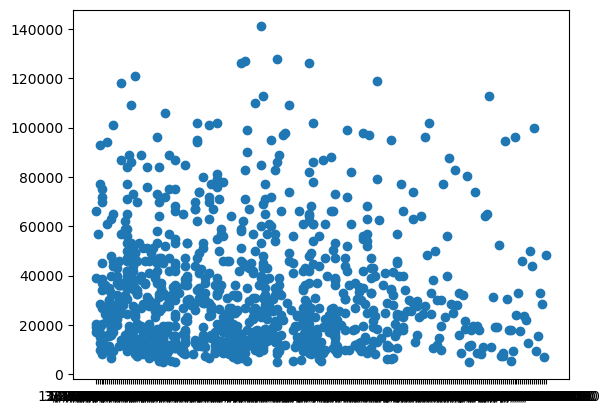

In [4]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

<Axes: ylabel='Frequency'>

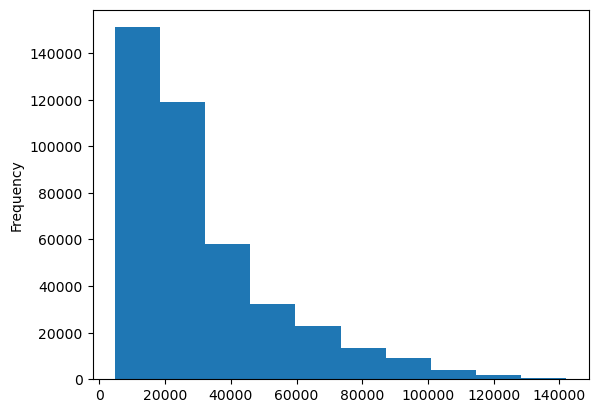

In [5]:
df.SalePrice.plot.hist()

### Parsing dates
When working with time series data, it's a good idea to make sure any date data is the format of a datetime object (a Python data type which encodes specific information about dates).

In [6]:
df = pd.read_csv('data/TrainAndValid.csv',
                 low_memory=False,
                 parse_dates=["saledate"])

In [7]:
# With parse_dates... check dtype of "saledate"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

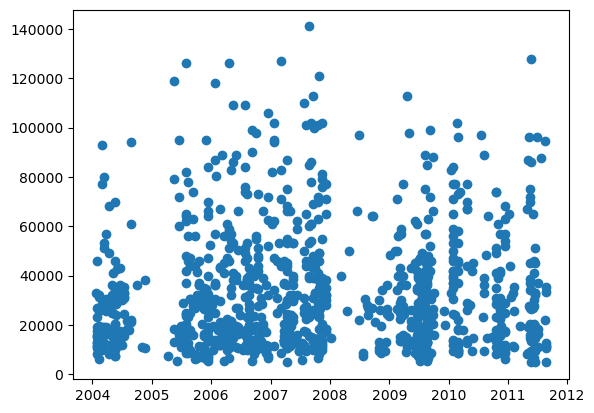

In [8]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [9]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [11]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate
As we're working on a time series problem and trying to predict future examples given past examples, it makes sense to sort our data by date.

In [12]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame
Since we're going to be manipulating the data, we'll make a copy of the original DataFrame and perform our changes there.

This will keep the original DataFrame in tact if we need it again.

In [13]:
# Make a copy of the original DataFrame to perform edits on
df_tmp = df.copy()

### Add datetime parameters for saledate column

In [14]:
# Add datetime parameters for saledate
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayofweek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayofyear"] = df_tmp.saledate.dt.dayofyear

# Drop original saledate
df_tmp.drop("saledate", axis=1, inplace=True)

In [15]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [16]:
# Check the different values of different columns
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

## 5. Modelling

In [17]:
# Check for missing categories and different datatypes
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [18]:
# Check for missing values
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Convert strings to categories
One way we can turn all of our data into numbers is by converting them into pandas catgories.

In [19]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [20]:
df_tmp["UsageBand"].dtype == 'object'

True

In [21]:
# These columns contain strings
c = 0
for label, content in df_tmp.items():
    if content.dtype == 'object':
        print(label)
        c += 1
print('--->', c, f'out of {len(df_tmp.columns)} colums contain object(string) datatypes')

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls
---> 44 out of 57 colums have object(string) datatypes


In [22]:
# This will turn all of the string values into category values
for label, content in df_tmp.items():
    if content.dtypes == 'object':
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [23]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [24]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [25]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

All of our data is categorical and thus we can now turn the categories into numbers, however it's still missing values...

In [26]:
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save Processed Data

In [27]:
# Save preprocessed data
df_tmp.to_csv('data/train_tmp.csv', index=False)

In [28]:
# Import preprocessed data
df_tmp = pd.read_csv('data/train_tmp.csv',
                     low_memory=False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [29]:
# Check missing values
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Fill missing values

### Filling numerical values first


In [30]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayofweek
saleDayofyear


In [31]:
df_tmp.ModelID

0          8434
1         10150
2          4139
3          8591
4          4089
          ...  
412693     5266
412694    19330
412695    17244
412696     3357
412697     4701
Name: ModelID, Length: 412698, dtype: int64

In [32]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [33]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells if the data was missing or not
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median since it's more robust than the mean
            df_tmp[label] = content.fillna(content.median())

In [34]:
# Demonstrate how median is more robust than mean
hundreds = np.full((1000,), 100)
hundreds_billion = np.append(hundreds, 1000000000)
np.mean(hundreds), np.mean(hundreds_billion), np.median(hundreds), np.median(hundreds_billion)

(100.0, 999100.8991008991, 100.0, 100.0)

In [35]:
# Check if there's any null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [36]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

### Filling and turning categorical variables to numbers
Now we've filled the numeric values, we'll do the same with the categorical values at the same time as turning them into numbers.

In [37]:
# Check columns which *aren't* numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [38]:
# Turn categorical variables into numbers
for label, content in df_tmp.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to inidicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        df_tmp[label] = pd.Categorical(content).codes+1  

In [39]:
pd.Categorical(df_tmp["state"]).codes+1

array([44,  9,  9, ...,  5,  5,  5], dtype=int8)

In [40]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [41]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that all of data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model.

In [42]:
df_tmp.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
SalesID,1646770,1821514,1505138,1671174,1329056,1301884,1379228,1645390,1493279,1449549,1449555,1453775,1264985,1475641,1364654
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0,23500.0,31000.0,11750.0,63000.0,13000.0,10500.0,20000.0,20000.0,23500.0,14000.0
MachineID,1126363,1194089,1473654,1327630,1336053,1182999,1082797,1527216,1363756,1289412,1102310,1514650,1204499,1194367,1270628
ModelID,8434,10150,4139,8591,4089,4123,7620,8202,2759,3356,3356,7008,6788,7277,7289
datasource,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False,False,True,True,False,True,True,True,True,True,True
Blade_Type_is_missing,False,True,False,True,False,False,True,True,False,True,True,True,True,True,True
Travel_Controls_is_missing,False,True,False,True,False,False,True,True,False,True,True,True,True,True,True
Differential_Type_is_missing,True,False,True,False,True,True,False,False,True,True,True,True,True,False,False


In [43]:
len(df_tmp)

412698

This will take a few minutes which is too long for interacting with it. So what we'll do is create a subset of rows to work with.

In [44]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)

CPU times: total: 1h 17min 30s
Wall time: 23min 9s


RandomForestRegressor(n_jobs=-1)

In [45]:
# Score the model
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)

0.9875587882218325

### Splitting data into train/valid sets

In [46]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


According to the Kaggle data page, the validation set and test set are split according to dates.

This makes sense since we're working on a time series problem.

E.g. using past events to try and predict future events.

Knowing this, randomly splitting our data into train and test sets using something like train_test_split() wouldn't work.

Instead, we split our data into training, validation and test sets using the date each sample occured.

In our case:

Training = all samples up until 2011
Valid = all samples form January 1, 2012 - April 30, 2012
Test = all samples from May 1, 2012 - November 2012
For more on making good training, validation and test sets, check out the post How (and why) to create a good validation set by Rachel Thomas.

In [47]:
df_tmp.saleYear.value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [48]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [49]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an evaluation function
There are  different levels of evaluation method; one is RMSLE-Root Mean Squared Log Error.
Since Scikit-Learn doesn't have a function built-in for RMSLE, we'll create our own.

We can do this by taking the square root of Scikit-Learn's mean_squared_log_error (MSLE). MSLE is the same as taking the log of mean squared error (MSE).

RMSLE = generally you don't care as much if you're off by $10 as much as you'd care if you were off by 10%, you care more about ratios rather than differences. MAE (mean absolute error) is more about exact differences.

In [50]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

## Testing our model on a subset (to tune the hyperparameters)
Retraing an entire model would take far too long to continuing experimenting as fast as we want to.

So what we'll do is take a sample of the training set and tune the hyperparameters on that before training a larger model.

In [51]:
len(X_train)

401125

In [52]:
# Change max samples in RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1,
                              random_state=1,
                              max_samples=10000)

In [53]:
%%time
# Cutting down the max number of samples each tree can see improves training time
model.fit(X_train, y_train)

CPU times: total: 2min 59s
Wall time: 55.5 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=1)

In [54]:
show_scores(model)

{'Training MAE': 5555.648537313806,
 'Valid MAE': 7126.526723407932,
 'Training RMSLE': 0.25749309696675654,
 'Valid RMSLE': 0.29266230044148844,
 'Training R^2': 0.8609662083836875,
 'Valid R^2': 0.8345830681097464}

### Hyperparameter tuning with RandomizedSearchCV

In [82]:
%%time

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1.0, "sqrt", "auto"], 
           "max_samples": [10000]}

#Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=1),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)

#Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 1min 12s
Wall time: 3min 54s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=1),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1.0, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [84]:
# Find the best parameters from the RandomizedSearch 
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 18,
 'min_samples_leaf': 3,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': 10}

### Train a model with the best parameters
In a model I prepared earlier, I tried 20 different combinations of hyperparameters (setting n_iter to 100 in RandomizedSearchCV) and found the best results came from the ones below.

Note: This kind of search on my computer (n_iter = 100) took ~2-hours. So it's kind of a set and come back later experiment.

We'll instantiate a new model with these discovered hyperparameters and reset the max_samples back to its original value.

In [85]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=1)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: total: 10min 51s
Wall time: 3min 22s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=1)

In [86]:
# Scores for ideal_model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2954.150601397537,
 'Valid MAE': 5955.2346645020425,
 'Training RMSLE': 0.1445415164924327,
 'Valid RMSLE': 0.24552209802536895,
 'Training R^2': 0.958897688820094,
 'Valid R^2': 0.8816339576760072}

With these new hyperparameters as well as using all the samples, we can see an improvement to our models performance.

You can make a faster model by altering some of the hyperparameters. Particularly by lowering n_estimators since each increase in n_estimators is basically building another small model.

However, lowering of n_estimators or altering of other hyperparameters may lead to poorer results.

## Make predictions on test data
Now we've got a trained model, it's time to make predictions on the test data.

In [87]:
df_test = pd.read_csv("data/Test.csv",
                      parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Preprocessing the test data
Our model has been trained on data formatted in the same way as the training data.

This means in order to make predictions on the test data, we need to take the same steps we used to preprocess the training data to preprocess the test data.

In [88]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df

Now let's preprocess the test dataset into the same format as our training dataset.

In [89]:
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [90]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


We've found that our test dataset (after preprocessing) has 101 columns where as, our training dataset (X_train) has 102 columns (after preprocessing).


In [91]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In this case, it's because the test dataset wasn't missing any auctioneerID fields.

To fix it, we'll add a column to the test dataset called auctioneerID_is_missing and fill it with False, since none of the auctioneerID fields are missing in the test dataset.

In [92]:
# Match test dataset columns to training dataset
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


There's one more step we have to do before we can make predictions on the test data.

And that's to line up the columns (the features) in our test dataset to match the columns in our training dataset.

As in, the order of the columnns in the training dataset, should match the order of the columns in our test dataset.

In [93]:
# Match column order from X_train to df_test (to predict on columns, they should be in the same order they were fit on)
df_test = df_test[X_train.columns]

Now the test dataset column names and column order matches the training dataset, we should be able to make predictions on it using our trained model.

In [94]:
# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)

In [95]:
test_preds

array([19639.04780633, 17151.50652405, 50349.13341587, ...,
       14470.18508183, 17663.380844  , 26113.11163295])

Let's make some format as a DataFrame that containing the SalesID and the predicted SalePrice of the bulldozer.

In [96]:
# Format predictions into the same format kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,19639.047806
1,1227844,17151.506524
2,1227847,50349.133416
3,1227848,65524.342664
4,1227863,55867.330953
...,...,...
12452,6643171,39468.956966
12453,6643173,12439.607318
12454,6643184,14470.185082
12455,6643186,17663.380844


In [97]:
# Export to csv...
df_preds.to_csv("data/predictions.csv",
               index=False)

### Feature Importance
Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the target variable (SalePrice).

In [98]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.31714405e-02, 1.74819021e-02, 4.51191761e-02, 1.75193141e-03,
       3.32571203e-03, 1.97690079e-01, 3.02880514e-03, 1.06589448e-03,
       4.13630217e-02, 5.37798282e-02, 6.54832705e-02, 5.04751158e-03,
       1.90619567e-02, 1.61500602e-01, 3.97673514e-02, 6.09388500e-03,
       3.85818916e-03, 1.50542276e-03, 3.86330978e-03, 5.97352787e-02,
       3.65492125e-04, 2.69527079e-04, 1.25552600e-03, 1.73491164e-04,
       1.29286270e-03, 1.11613632e-04, 7.48892590e-04, 4.42250721e-03,
       4.77498340e-04, 9.42576141e-05, 3.72873551e-03, 5.32916053e-03,
       3.78547094e-03, 7.10515413e-04, 3.17997673e-03, 7.97712937e-03,
       7.48202392e-04, 1.39675264e-02, 1.45413108e-03, 1.28146695e-03,
       8.17911149e-04, 9.85453542e-04, 3.27319376e-03, 5.51103989e-04,
       7.94387981e-04, 3.27146630e-04, 2.21744347e-04, 3.63353900e-03,
       9.36744463e-04, 3.72683884e-04, 4.05028130e-04, 7.39234625e-02,
       3.81385597e-03, 5.67275852e-03, 2.91234222e-03, 9.77816059e-03,
      

In [99]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sb.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

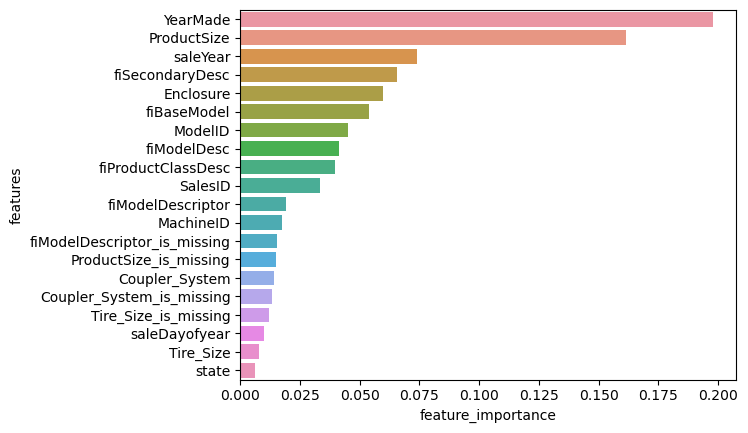

In [100]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [101]:
sum(ideal_model.feature_importances_)

0.9999999999999999

In [102]:
df.ProductSize.isna().sum()

216605

In [103]:
df.ProductSize.value_counts()

ProductSize
Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: count, dtype: int64

In [104]:
df.Turbocharged.value_counts()

Turbocharged
None or Unspecified    77111
Yes                     3985
Name: count, dtype: int64

In [105]:
df.Thumb.value_counts()

Thumb
None or Unspecified    85074
Manual                  9678
Hydraulic               7580
Name: count, dtype: int64